In [1]:
import jax
jax.config.update("jax_enable_x64", True)

from jax import numpy as jnp
from jax import vmap, grad, jit
from jax.scipy.special import sph_harm

import s2fft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt


def to_points(theta, phi, r=1):
    x = r * jnp.sin(theta) * jnp.cos(phi)
    y = r * jnp.sin(theta) * jnp.sin(phi)
    z = r * jnp.cos(theta)
    return x, y, z


def colormap(x):
    cmap = plt.get_cmap('viridis', 256)
    return cmap(x)


def normalize(v):
    max = jnp.max(v)
    min = jnp.min(v)
    return (v - min) / (max - min)


def sph_plot(f, theta, phi, ax):
    theta, phi = jnp.meshgrid(theta, phi)
    x, y, z = to_points(theta, phi)
    ax.plot_surface(x, y, z, facecolors=f, rstride=1, cstride=1, shade=False)


def rotation_plot(alphas, betas, N):
    gammas = jnp.zeros_like(alphas)
    t = jnp.linspace(0, 2*jnp.pi, N+1)[:-1]
    x0, y0, z0 = jnp.cos(t), jnp.sin(t), jnp.zeros_like(t)
    i1, i2 = 0, 5
    
    # Plot sampling points
    plt.figure(figsize=(15, 5))
    
    ax = plt.subplot(141, projection='3d')
    plt.title("Sampled angles")
    ax.scatter(*to_points(betas, alphas, r=1), color='r')
    
    # Scatter rotated pooints for alpha[i], beta[i] rotation
    ax = plt.subplot(142, projection='3d')
    plt.title("Example rotation 1")
    ax.scatter(*rotate_points(x0, y0, z0, alphas[i1], betas[i1], gammas[i1]), color='r')
    ax.plot(*[[0., p] for p in rotate_point(0, 0, 1., alphas[i1], betas[i1], gammas[i1])], color='b')
    
    ax = plt.subplot(143, projection='3d')
    plt.title("Example rotation 2")
    ax.scatter(*rotate_points(x0, y0, z0, alphas[i2], betas[i2], gammas[i2]), color='r')
    ax.plot(*[[0., p] for p in rotate_point(0, 0, 1., alphas[i2], betas[i2], gammas[i2])], color='b')
    
    ax = plt.subplot(144, projection='3d')
    plt.title("Coverage")
    for i in range(len(alphas)):
        ax.scatter(*rotate_points(x0, y0, z0, alphas[i], betas[i], gammas[i]), color='b')
    ax.scatter(*to_points(betas, alphas, r=1), color='r')
    ax.view_init(elev=0, azim=90)


def Xrot(alpha):
    return jnp.array([
        [1, 0, 0],
        [0, jnp.cos(alpha), -jnp.sin(alpha)],
        [0, jnp.sin(alpha), jnp.cos(alpha)]
    ])
    
def Yrot(beta):
    return jnp.array([
        [jnp.cos(beta), 0, jnp.sin(beta)],
        [0, 1, 0],
        [-jnp.sin(beta), 0, jnp.cos(beta)]
    ])


def Zrot(gamma):
    return jnp.array([
        [jnp.cos(gamma), -jnp.sin(gamma), 0],
        [jnp.sin(gamma), jnp.cos(gamma), 0],
        [0, 0, 1]
    ])
    

def ZYZrot(alpha, beta, gamma):
    return Zrot(alpha) @ Yrot(beta) @ Zrot(gamma)


def rotate_point(x, y, z, alpha, beta, gamma):
    R = ZYZrot(alpha, beta, gamma)
    xyz = (R @ jnp.array([[x, y, z]]).T).squeeze()
    return xyz[0], xyz[1], xyz[2]


def rotate_points(x,y,z, alpha, beta, gamma):
    R = ZYZrot(alpha, beta, gamma)
    xyz = vmap(lambda xi,yi,zi: R @ jnp.array([[xi, yi, zi]]).T)(x, y, z)
    return xyz[:,0], xyz[:,1], xyz[:,2]


def inv_rotate_points(x,y,z,alpha, beta, gamma):
    return rotate_points(x, y, z, -gamma, -beta, -alpha)


def inv_rotate_point(x,y,z,alpha, beta, gamma):
    return rotate_point(x, y, z, -gamma, -beta, -alpha)


def polar_to_rotated(alpha, beta, phi):
    x = jnp.cos(beta)*jnp.cos(alpha)*jnp.cos(phi) - jnp.sin(beta)*jnp.sin(phi)
    y = jnp.sin(beta)*jnp.cos(alpha)*jnp.cos(phi) + jnp.cos(beta)*jnp.sin(phi)
    z = -jnp.sin(alpha)*jnp.cos(phi)
    return x, y, z

def sph_parity_plot(f, thetas, phis):
    plt.figure(figsize=(15, 5))
    
    ax = plt.subplot(141, projection='3d')
    plt.title("Re F(r)")
    v = colormap(normalize(f.real))
    sph_plot(v, thetas, phis, ax)
    
    ax = plt.subplot(142, projection='3d')
    plt.title("Re F(-r)")
    v = colormap(normalize(f.real))
    sph_plot(v, jnp.pi - thetas, phis + jnp.pi, ax)

    ax = plt.subplot(143, projection='3d')
    plt.title("Im F(r)")
    v = colormap(normalize(f.imag))
    sph_plot(v, thetas, phis, ax)

    ax = plt.subplot(144, projection='3d')
    plt.title("Imag F(-r)")
    v = colormap(normalize(-f.imag))
    sph_plot(v, jnp.pi - thetas, phis + jnp.pi, ax)


def eval_shell(theta, phi, fm, ls, ms, L_max):
    # sph_harm uses different conventions for theta and phi
    theta, phi = phi, theta
    return jnp.sum(sph_harm(ms, ls, jnp.array([theta]), jnp.array([phi]), n_max=L_max) * fm)
    #return jnp.sum(basis(ms) * fm)


def sph_rot(fm, alpha, d_beta, gamma, ms):
    return jnp.exp(-1j*ms*alpha) * jnp.einsum('ij,j->i', d_beta, jnp.exp(-1j*ms*gamma) * fm)


def sph_rot_slice(fm, alpha, d_beta, gamma, ms, sph_zero):
    return sph_rot(fm, alpha, d_beta, gamma, ms) * sph_zero


def get_slicing_weights(betas, ms, L):
    d_beta = vmap(lambda beta: s2fft.utils.rotation.generate_rotate_dls(L, beta)[-1, :, :])(betas)
    sph_zero = sph_harm(ms, jnp.ones_like(ms)*(L-1), 0., jnp.pi/2)
    return d_beta, sph_zero


def random_signal(L, key):
    key1, key2 = jax.random.split(key)
    ms = jnp.arange(-(L-1), (L-1)+1).astype(jnp.int32)
    f = jax.random.normal(key1, shape=(2*L-1)) + 1j * jax.random.normal(key2, shape=(2*L-1))
    f = f + (-1)**(L-1-ms)*jnp.conjugate(f[::-1])
    return f

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


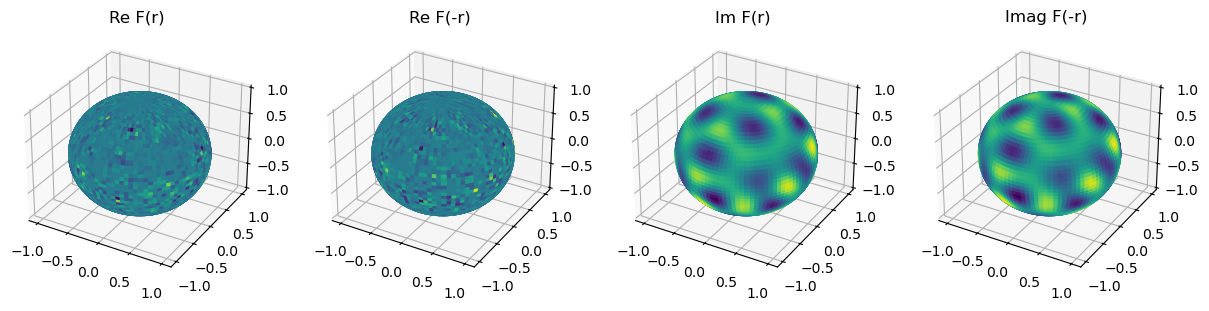

In [2]:
# Indices
L = 10
ms = jnp.arange(-(L-1), (L-1)+1)#.astype(jnp.int32)
ls = jnp.ones_like(ms)*(L-1)

# Eval grid
thetas = jnp.linspace(0, jnp.pi, 50)
phis = jnp.linspace(0, 2*jnp.pi, 101)#[:-1]
Theta, Phi = jnp.meshgrid(thetas, phis)

# Signal
fm = random_signal(L, jax.random.PRNGKey(0))
f_wrap = jit(lambda theta, phi: eval_shell(theta, phi, fm, ls, ms, L))
f = vmap(vmap(f_wrap, (0, None)), (None, 0))(thetas, phis)

# Plot
sph_parity_plot(f, thetas, phis)

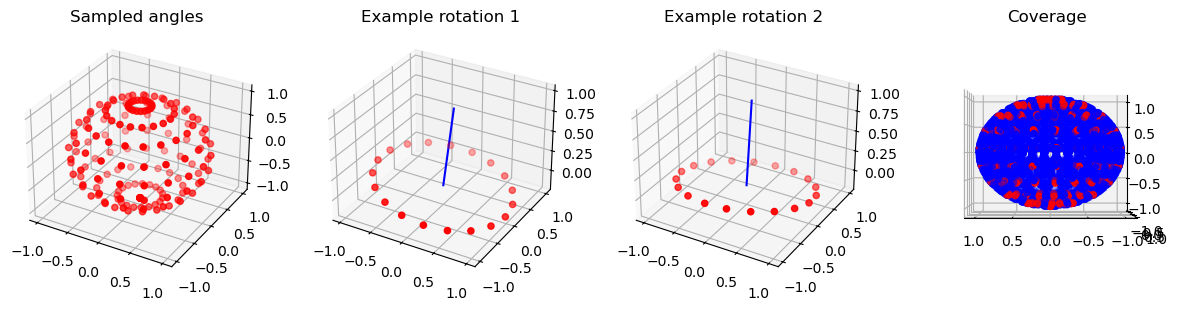

In [3]:
# Rotational Sampling
sampling, Lmax = "mw", L
alphas = s2fft.sampling.s2_samples.phis_equiang(Lmax, sampling)
betas = s2fft.sampling.s2_samples.thetas(Lmax, sampling)
Alphas, Betas = jnp.meshgrid(alphas, betas)
Alphas, Betas = Alphas.flatten(), Betas.flatten()

rotation_plot(Alphas, Betas, (2*L-1))

(-1.4666666666666668,
 1.4666666666666668,
 -1.4668336068237697,
 1.4664997265095638,
 -1.1,
 1.1)

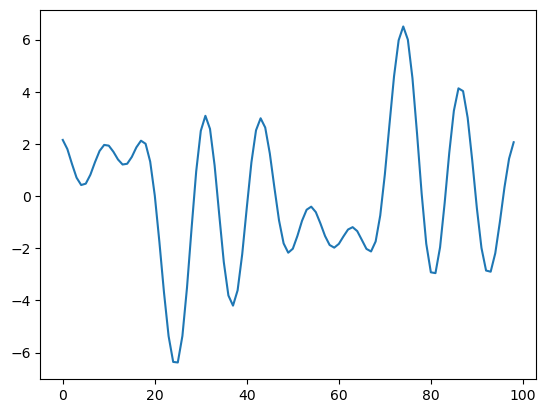

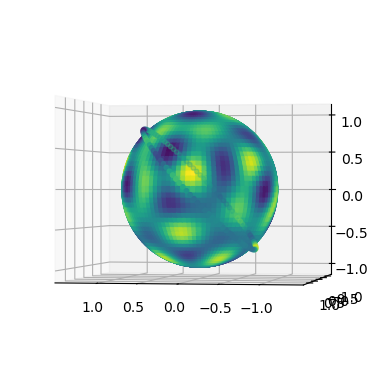

In [20]:
from jax.numpy.fft import ifft, fft
d_beta, sph_zero = get_slicing_weights(betas, ms, L)
fm_rot_func = lambda d, alpha: sph_rot(fm, alpha, d, 0., ms)
f_rot_func = lambda d, alpha, theta, phi: eval_shell(theta, phi, fm_rot_func(d, alpha), ls, ms, L)
f_rot_grid = lambda d, alpha: vmap(vmap(f_rot_func, (None, None, 0, None)), (None, None, None, 0))(d, alpha, thetas, phis)

#d_beta, sph_zero = get_slicing_weights(jnp.array([0]), ms, L)
idx_beta = 2
alpha_test = alphas[4]
beta_test = betas[idx_beta]
d_beta_test = d_beta[idx_beta]

sph_slice = sph_rot_slice(fm, alpha_test, d_beta_test, 0., ms, sph_zero)

t = jnp.linspace(0,2*jnp.pi, 100)[:-1]# jnp.linspace(0,2*jnp.pi, len(sph_slice)+1)[:-1]#phis
#t = phis
sph_slice_ifft = vmap(lambda t: jnp.sum(sph_slice * jnp.exp(1j*t*ms)))(t) #
#sph_slice_ifft = ifft(jnp.roll(sph_slice, len(sph_slice)//2+1))
x0, y0, z0 = jnp.cos(t), jnp.sin(t), jnp.zeros_like(t)
x_slice, y_slice, z_slice = inv_rotate_points(x0, y0, z0, alpha_test, beta_test, 0.)
#x_slice2, y_slice2, z_slice2 = vmap(polar_to_rotated, (None, None, 0))(alpha_test, beta_test, t)


plt.plot(sph_slice_ifft.imag)

plt.figure()
ax = plt.subplot(111, projection='3d')
r = 1.05
ax.scatter(x_slice*r, y_slice*r, z_slice*r, s=10, c=colormap((sph_slice_ifft.imag-jnp.min(f.imag))/(jnp.max(f.imag)-jnp.min(f.imag))))
#ax.scatter(x_slice2*r, y_slice2*r, z_slice2*r, s=10, c=colormap(normalize(sph_slice_ifft.imag)))
sph_plot(colormap(normalize(f.imag)), thetas, phis, ax)
ax.view_init(elev=0, azim=100)#120)
plt.axis("equal")


In [ ]:


plt.figure(figsize=(15, 15))

for i in range(len(alphas)):
    for j in range(len(betas)):
        ai = alphas[i]
        bi = betas[j]
        di = d_beta[j]
        fi = f_rot_grid(di, ai)

        ax = plt.subplot(len(alphas), len(betas), i*len(betas)+j+1, projection='3d')
        sph_plot(colormap(jnp.abs(fi.imag)), thetas, phis, ax)
    
    #plt.figure(2)
    #ax = plt.subplot(nfig_col, nfig_row, i+1)
    #di = jnp.exp(-1j*ms[:,None]*alphas[i])*d[i]*jnp.exp(-1j*ms[None,:]*gammas[i])
    #plt.imshow(jnp.abs(di))
    


In [ ]:
#
# Angle recovery
#   # Step 0: Precompute Wigner-D matrices and Great Circle Fourier Coefficients
        # Step 0a: Precompute Wigner-D matrices
            # wigner_D = vmap(s2fft.recursion_etc)(alphas, betas)
        # Step 0b: Precompute Great Circle Fourier Coefficients
    # Step 1: Iterate over alpha, beta
        # Step 1a: compute optimal plane rot phi, and correlation c
        # phi_max, corr_max = vmap(lambda alpha, beta: opt_rot(alpha, beta, fm, data))(alphas, betas)
            # step 1aa: rotate fm by alpha, beta using wigner-D (PRECOMPUTE: step 0)
            # step 1ab: extract fourier coefficients of rotated signal at great circle (PRECOMPUTE: step 0)
            # step 1ac: compute correlation between rotated signal and data
            # corr(afft,bfft) = ifft(afft*conj(bfft))
            # cval = corr(data_fft, slice(alpha, beta, flm))  ### Big question: Why is this the correlation??? Real vs Complex space
            # idmax = argmax(cval)
            # return phi[idmax], cval[idmax]
            
    # Step 3: Extract alpha_max, beta_max, phi_max
    
    # argmax -> alpha_max, beta_max, phi_max
    
# Averaging
# 